In [94]:
import numpy as np
from matplotlib import pyplot as plt
import math
import random

In [95]:
def f(x):
    return 3 * x**2 - 2 * x + 1

In [96]:
y = f(3.0)
y

22.0

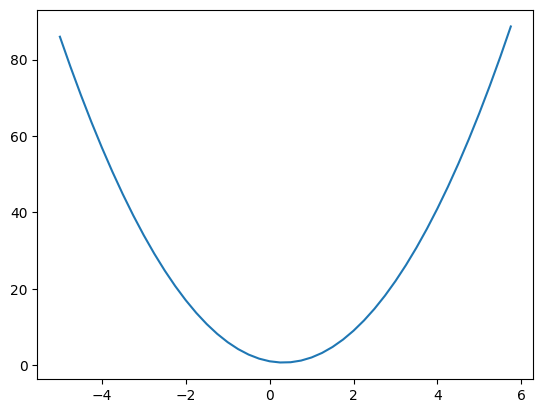

In [97]:
xs = np.arange(-5, 6, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [98]:
h = 0.000000000000001
x = 0.35
df = (f(x + h) - f(x)) / h
df

0.11102230246251564

In [99]:
h = 0.0001

a = 2.0
b = -2.0
c = 5.0
d1 = a * b + c
c += h
d2 = a * b + c
print(d2, (d2 - d1) / h)

1.0000999999999998 0.9999999999976694


In [100]:
class Value:
    def __init__(self, data, _prev=(), _op="", _label=""):
        self.data = data
        self._grad = 0.0
        self._backward = lambda: None
        self._prev = set(_prev)
        self._op = _op
        self._label = _label

    def __repr__(self):
        return f"Value({self.data})"
    
    def __radd__(self, other):
        return self + other

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self._grad += 1 * out._grad
            other._grad += 1 * out._grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data ** other.data, (self, other), "**")

        def _backward():
            self._grad += other.data * (self.data ** (other.data - 1)) * out._grad
            other._grad += math.log(self.data) * (self.data ** other.data) * out._grad

        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self._grad += other.data * out._grad
            other._grad += self.data * out._grad

        out._backward = _backward

        return out

    def tanh(self):
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)

        out = Value(t, (self,), "tanh")

        def _backward():
            self._grad += (1 - t**2) * out._grad

        out._backward = _backward

        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp")

        def _backward():
            self._grad += math.exp(self.data) * out._grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                    topo.append(v)

        build_topo(self)

        self._grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, _label="a")
a._grad = -8.0
b = Value(-2.0, _label="b")
b._grad = 8.0
c = Value(5.0, _label="c")
c._grad = 4.0
e = a * b
e._label = "e"
e._grad = 4.0
d = e + c
d._label = "d"
d._grad = 4.0
f = Value(4.0, _label="f")
f._grad = 1.0
L1 = d * f
L1._label = "L"
L1._grad = 1.0

In [101]:
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()

    def build(node):
        if node not in nodes:
            nodes.add(node)
            for prev in node._prev:
                edges.add((prev, node))
                build(prev)

    build(root)
    return nodes, edges


def plot_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(uid, label="{ %s | data %0.4f | grad %0.4f }" % (n._label, n.data, n._grad), shape="record")
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

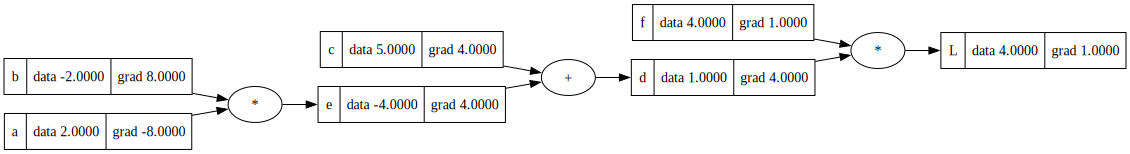

In [102]:
plot_dot(L1)

In [103]:
def lol():
    h = 1e-4

    a = Value(2.0, _label="a")
    b = Value(-2.0, _label="b")
    c = Value(5.0, _label="c")
    e = a * b
    e._label = "e"
    d = e + c
    d._label = "d"
    f = Value(4.0, _label="f")
    L1 = d * f
    L1._label = "L"
    L1._grad = 1.0

    a = Value(2.0, _label="a")
    b = Value(-2.0, _label="b")
    c = Value(5.0, _label="c")
    e = a * b
    e._label = "e"
    d = e + c
    d._label = "d"
    d.data += h
    f = Value(4.0, _label="f")
    L2 = d * f
    L2._label = "L"
    L2._grad = 1.0

    return (L2.data - L1.data) / h


lol()

3.9999999999995595

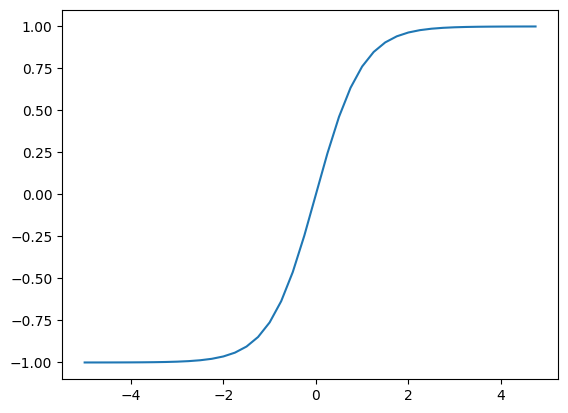

In [104]:
xs = np.arange(-5, 5, 0.25)
ys = np.tanh(xs)
plt.plot(xs, ys)

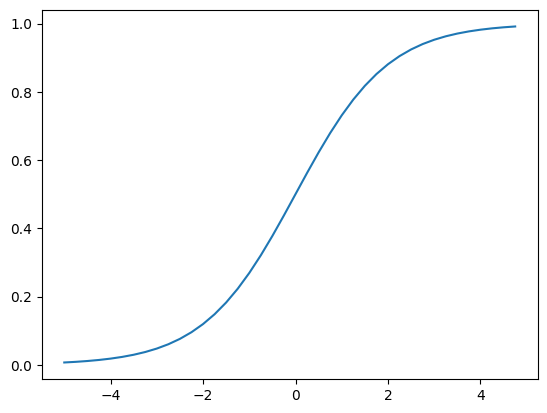

In [105]:
xs = np.arange(-5, 5, 0.25)
ys = 1 / (1 + np.exp(-xs))  # sigmoid
plt.plot(xs, ys)

In [106]:
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")

w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")

b = Value(6.8813736870195432, _label="b")

x1w1 = x1 * w1
x1w1._label = "x1w1"
x2w2 = x2 * w2
x2w2._label = "x2w2"

w1x1w2x2 = x1w1 + x2w2
w1x1w2x2._label = "x1w1 + x2w2"

n = w1x1w2x2 + b
n._label = "n"
o = n.tanh()
o._label = "o"


In [107]:
o._grad = 1.0

n._grad = o._grad * (1 - o.data**2)

w1x1w2x2._grad = n._grad
b._grad = n._grad

x1w1._grad = w1x1w2x2._grad
x2w2._grad = w1x1w2x2._grad

w1._grad = x1.data * x1w1._grad
x1._grad = w1.data * x1w1._grad

w2._grad = x2.data * x2w2._grad
x2._grad = w2.data * x2w2._grad

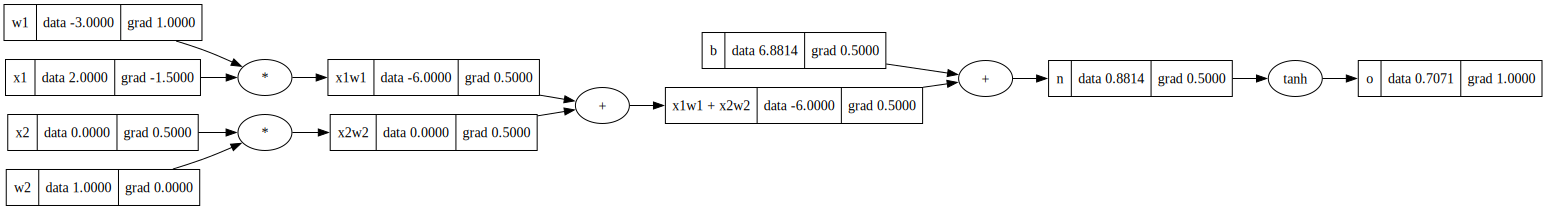

In [108]:
plot_dot(o)

In [109]:
# inputs x1,x2
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
# weights w1,w2
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
# bias of the neuron
b = Value(6.8813735870195432, _label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1._label = "x1*w1"
x2w2 = x2 * w2
x2w2._label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2._label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n._label = "n"
o = n.tanh()
o._label = "o"

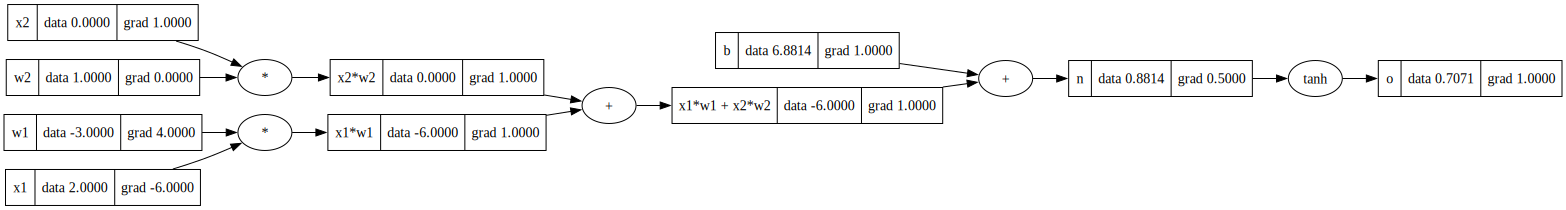

In [110]:
o.backward()

plot_dot(o)

In [111]:
# inputs x1,x2
x1 = Value(2.0, _label="x1")
x2 = Value(0.0, _label="x2")
# weights w1,w2
w1 = Value(-3.0, _label="w1")
w2 = Value(1.0, _label="w2")
# bias of the neuron
b = Value(6.8813735870195432, _label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1._label = "x1*w1"
x2w2 = x2 * w2
x2w2._label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2._label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n._label = "n"
# tanh(n):
e = (2*n).exp()
o = (e - 1) / (e + 1)
o._label = "o"

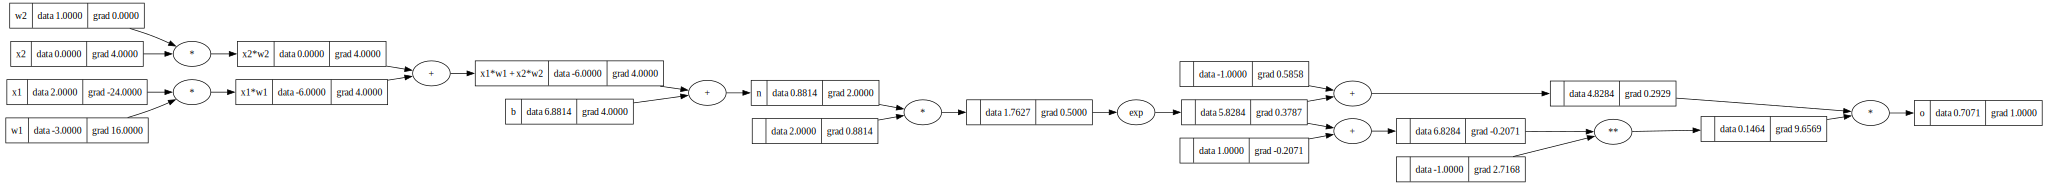

In [112]:
o.backward()

plot_dot(o)

In [113]:
from torch import Tensor

x1 = Tensor([2.0]).double()
x1.requires_grad = True

x2 = Tensor([0.0]).double()
x2.requires_grad = True


w1 = Tensor([-3.0]).double()
w1.requires_grad = True

w2 = Tensor([1.0]).double()
w2.requires_grad = True

b = Tensor([6.8813735870195432]).double()
b.requires_grad = True

n = x1 * w1 + x2 * w2 + b
o = n.tanh()

o.backward()

print(o.data.item())
print("--------------------")
x1.grad, x2.grad, w1.grad, w2.grad, b.grad

0.7071066904050358
--------------------


(tensor([-1.5000], dtype=torch.float64),
 tensor([0.5000], dtype=torch.float64),
 tensor([1.0000], dtype=torch.float64),
 tensor([0.], dtype=torch.float64),
 tensor([0.5000], dtype=torch.float64))

In [114]:
class Neuron:
    def __init__(self, nin):
        self.w = [ Value(random.uniform(-1, 1)) for _ in range(nin) ]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum(([x*w for x, w in zip(x, self.w)]), self.b)
        out = act.tanh()
        return out


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
mlp = n(x)
mlp

Value(-0.9358194856245693)

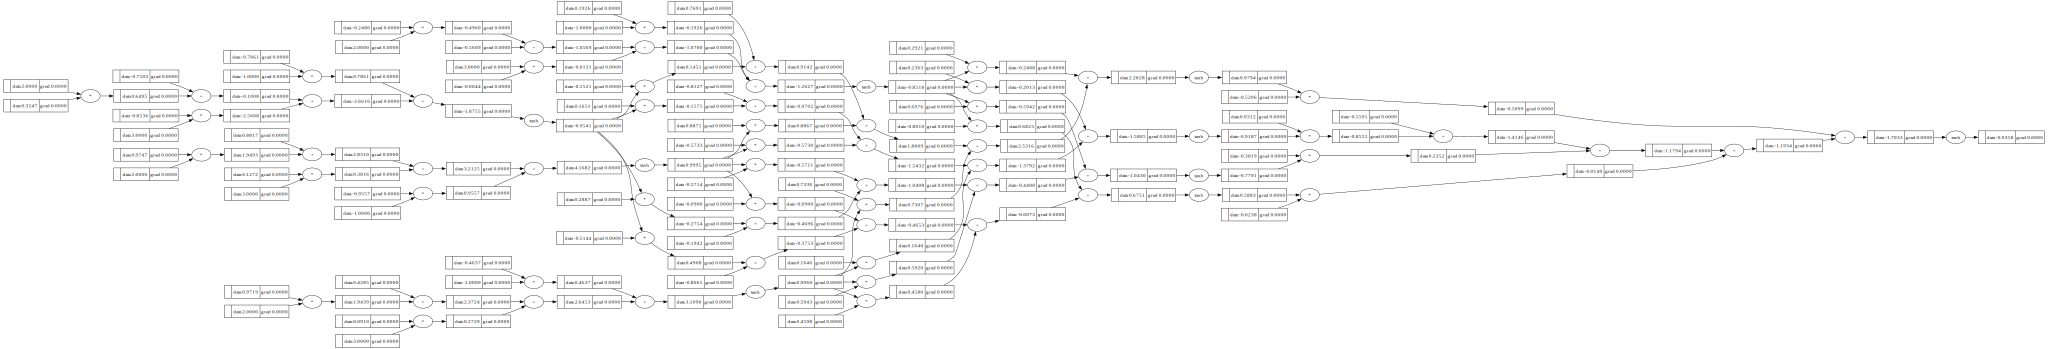

In [115]:
plot_dot(mlp)

In [116]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, 1.0, -1.0]
ypreds = [n(x) for x in xs]
ypreds

[Value(-0.9358194856245693),
 Value(-0.9364147827013378),
 Value(-0.9278543331578122),
 Value(-0.9359999818633851)]

In [119]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypreds))
loss

Value(7.47215849297953)

In [120]:
loss.backward()

ValueError: math domain error